In [1]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd
import matplotlib.gridspec as gridspec
import datetime
import math
import scipy.stats as stats
import sklearn

# Import regression modules
import statsmodels.api as sm
from statsmodels.formula.api import ols

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib notebook
from IPython.core.display import display, HTML
display(HTML("<style>.rendered_html{font-size: 18px; line-height: 1.4}</style>"))

# special IPython command to prepare the notebook for matplotlib and other libraries
%matplotlib inline 

In [2]:
Housing_data = pd.read_csv('cleaned_1.csv')
Housing_data = Housing_data.set_index(['parcelid','Unnamed: 1'])
del Housing_data['garagetotalsqft'] # this has a very large amount of missing data, so will be excluded for now
Housing_data['transactiondate'] = pd.to_datetime(Housing_data['transactiondate'], 
                                                 format = '%Y-%m-%d', errors = 'coerce')
Housing_data['yearbuilt'] = pd.to_datetime(Housing_data['yearbuilt'], format='%Y.0', errors='coerce').dt.year
Housing_data['assessmentyear'] = pd.to_datetime(Housing_data['assessmentyear'], 
                                                format='%Y-%m-%d', errors='coerce').dt.year
Housing_data['taxdelinquencyyear'] = pd.to_datetime(Housing_data['taxdelinquencyyear'], 
                                                    format='%Y-%m-%d', errors='coerce').dt.year

House_df = Housing_data.drop(['taxdelinquencyyear'], axis = 1)
House_df = House_df.dropna()
House_df['yearbuiltint'] = House_df['yearbuilt'].astype(int)
House_df.head()


,,airconditioningtypeid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,garagecarcnt,...,bathroom_number_category,decktypeid,poolsizesum,yardbuildingsqft17,yardbuildingsqft26,fireplacecnt,pooltypeid,transactiondate,logerror,yearbuiltint
parcelid,Unnamed: 1,,,,,,,,,,,,,,,,,,,,,
17073783,0,-1,2,3.0,-1,2.5,1264.0,1264.0,6111,2,2,...,0,0,0.0,128.0,0.0,0,0,2016-01-27,0.0953,1986
17100444,2,-1,2,3.0,-1,2.0,1101.0,1101.0,6111,2,2,...,2,0,0.0,0.0,0.0,0,0,2016-05-27,0.0060,1956
17102429,3,-1,1,2.0,-1,1.5,1554.0,1554.0,6111,1,2,...,3,0,0.0,0.0,0.0,1,0,2016-06-07,-0.0566,1965
17109604,4,-1,2,4.0,-1,2.5,2415.0,2415.0,6111,2,2,...,0,0,0.0,0.0,0.0,1,0,2016-08-08,0.0573,1984
17125829,5,-1,2,4.0,-1,2.5,2882.0,2882.0,6111,2,2,...,0,1,0.0,0.0,0.0,1,0,2016-08-26,0.0564,1980


Text(0.5,0,'regionidcounty')

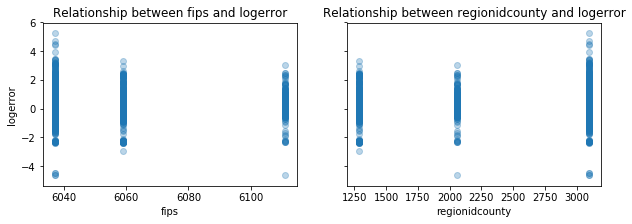

In [3]:
# Two subplots, unpack the axes array immediately
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize = (10,3))
ax1.set_ylabel("logerror")
ax1.scatter(House_df['fips'], House_df['logerror'], alpha = 0.3)
ax1.set_title("Relationship between fips and logerror")
ax1.set_xlabel("fips")
ax2.scatter(House_df['regionidcounty'], House_df['logerror'], alpha = 0.3)
ax2.set_title("Relationship between regionidcounty and logerror")
ax2.set_xlabel("regionidcounty")

Text(0.5,0,'regionidcity')

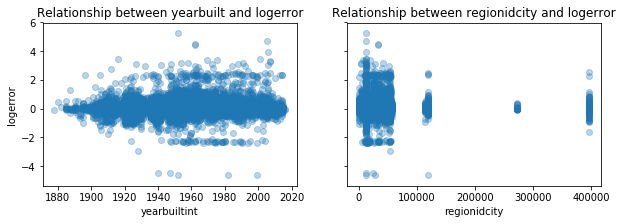

In [4]:
# Two subplots, unpack the axes array immediately
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize = (10,3))
ax1.set_ylabel("logerror")
ax1.scatter(House_df['yearbuiltint'], House_df['logerror'], alpha = 0.3)
ax1.set_title("Relationship between yearbuilt and logerror")
ax1.set_xlabel("yearbuiltint")
ax2.scatter(House_df['regionidcity'], House_df['logerror'], alpha = 0.3)
ax2.set_title("Relationship between regionidcity and logerror")
ax2.set_xlabel("regionidcity")

In [5]:
cols_for_lin = ['yearbuiltint', 'latitude', 'longitude', 'propertycountylandusecode', 
               'propertyzoningdesc', 'calculatedbathnbr', 'landtaxvaluedollarcnt', 'structuretaxvaluedollarcnt',
               'taxvaluedollarcnt', 'taxamount']
linstr = ('logerror ~ yearbuiltint + latitude + longitude + propertycountylandusecode + '
          'propertyzoningdesc + calculatedbathnbr + taxamount + landtaxvaluedollarcnt + '
          'structuretaxvaluedollarcnt + taxvaluedollarcnt'
         )
print(linstr)

logerror ~ yearbuiltint + latitude + longitude + propertycountylandusecode + propertyzoningdesc + calculatedbathnbr + taxamount + landtaxvaluedollarcnt + structuretaxvaluedollarcnt + taxvaluedollarcnt


In [6]:
m_house = ols(linstr,House_df).fit()
print(m_house.summary())

                            OLS Regression Results                            
Dep. Variable:               logerror   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     43.02
Date:                Sun, 02 Sep 2018   Prob (F-statistic):           9.80e-78
Time:                        23:49:50   Log-Likelihood:                 58754.
No. Observations:              141037   AIC:                        -1.175e+05
Df Residuals:                  141027   BIC:                        -1.174e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

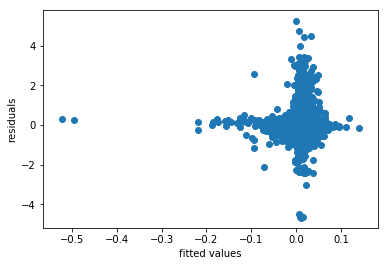

In [7]:
plt.figure()
plt.xlabel("fitted values")
plt.ylabel("residuals")
plt.scatter(m_house.fittedvalues,m_house.resid)

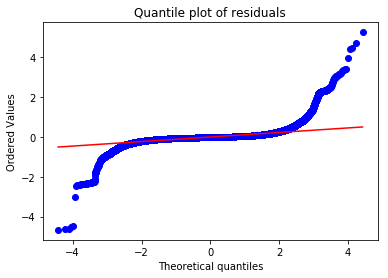

In [8]:
import pylab
plt.figure()
stats.probplot(m_house.resid, dist="norm", plot=pylab)
pylab.title("Quantile plot of residuals")
pylab.show()

In [9]:
influence = m_house.get_influence()
#c is the distance and p is p-value
(c, p) = influence.cooks_distance
leverage = influence.hat_matrix_diag

In [ ]:
plt.figure()
plt.stem(np.arange(len(c)), c, markerfmt=",")

KeyboardInterrupt: 

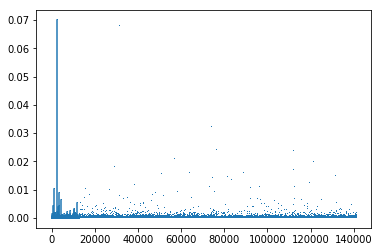

In [10]:
plt.figure()
plt.stem(np.arange(len(leverage)), leverage, markerfmt=",")

In [ ]:
from statsmodels.graphics.regressionplots import *
plot_leverage_resid2(m_house)
influence_plot(m_house)